In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from matplotlib.colors import ListedColormap
from torch.utils.data import Dataset, DataLoader

In [2]:
class Data(Dataset):

    def __init__(self, n = 50, std = 1, train = True):
        self.std = std
        self.x = torch.linspace(-1, 1, n).view(-1,1)
        self.f = self.x**3
        self.len = self.x.size()[0]
        if train is False:
            torch.manual_seed(0)
            self.y = (self.f + std * torch.randn(n).view(-1,1)).view(-1,1)
            torch.manual_seed(1)
        else:
            self.y = (self.f + std * torch.randn(n).view(-1,1)).view(-1,1)

    def __getitem__(self, item):
        return self.x[item], self.y[item]

    def __len__(self):
        return self.len

    def plot_data(self):
        plt.plot(self.x,self.f, label = "True function $f$")
        plt.plot(self.x,self.y, 'o', label = "Noisy data")
        plt.legend()


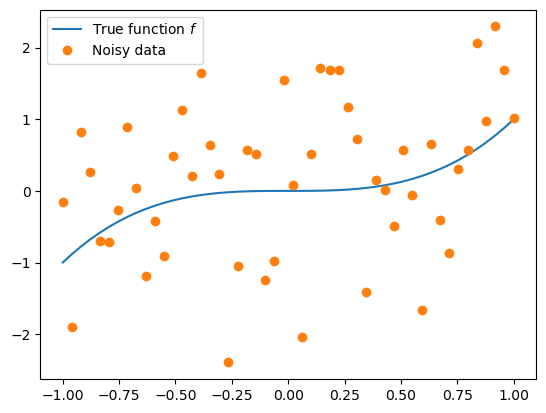

In [3]:
data = Data()
data_train = Data(train=True)
data.plot_data()

In [4]:
class Net(nn.Module):
    # Constructor
    def __init__(self, Layers):
        super(Net, self).__init__()
        self.hidden = nn.ModuleList()
        for input_size, output_size in zip(Layers, Layers[1:]):
            self.hidden.append(nn.Linear(input_size, output_size))

    # Prediction
    def forward(self, activation):
        L = len(self.hidden)
        for (l, linear_transform) in zip(range(L), self.hidden):
            if l < L - 1:
                activation = F.relu(linear_transform(activation))
            else:
                activation = linear_transform(activation)
        return activation

In [5]:
class Net_DO(nn.Module):
    def __init__(self, in_dim, dim_h, dim_out, p=0):
        super(Net_DO, self).__init__()
        self.drop = nn.Dropout(p=p)
        self.linear1 = nn.Linear(in_dim, dim_h)
        self.linear2 = nn.Linear(dim_h, dim_h)
        self.linear3 = nn.Linear(dim_h, dim_out)

    def forward(self, x):
        x = F.relu(self.drop(self.linear1(x)))
        x = F.relu(self.drop(self.linear2(x)))
        x = self.linear3(x)
        return x

In [6]:
layers = [1,300,300,1]
model = Net(layers)
model_do = Net_DO(1,300,1,p=0.5)
model_do.train()
lr = 0.01
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = lr)
optimizer_do = torch.optim.Adam(model_do.parameters(), lr = lr)

In [7]:
def train_model(epochs):
    LOSS = []; LOSS_VAL = []; LOSS_DO = []; LOSS_DO_VAL = []

    for epoch in range(epochs):
        optimizer.zero_grad()
        optimizer_do.zero_grad()
        yhat = model(data_train.x)
        yhat_do = model_do(data_train.x)
        loss = criterion(yhat,data_train.y)
        loss_val = criterion(model(data.x),data.y)
        loss_do = criterion(yhat_do,data_train.y)
        loss_val_do = criterion(model_do(data.x),data.y)
        LOSS.append(loss.detach())
        LOSS_VAL.append(loss_val.detach())
        LOSS_DO.append(loss_do.detach())
        LOSS_DO_VAL.append(loss_val_do.detach())
        loss.backward()
        loss_do.backward()
        optimizer.step()
        optimizer_do.step()
    return LOSS_VAL,LOSS_DO_VAL, LOSS,LOSS_DO

val_loss, val_loss_do, train_loss,training_loss_do = train_model(500)

In [8]:
model_do.eval()

Net_DO(
  (drop): Dropout(p=0.5, inplace=False)
  (linear1): Linear(in_features=1, out_features=300, bias=True)
  (linear2): Linear(in_features=300, out_features=300, bias=True)
  (linear3): Linear(in_features=300, out_features=1, bias=True)
)

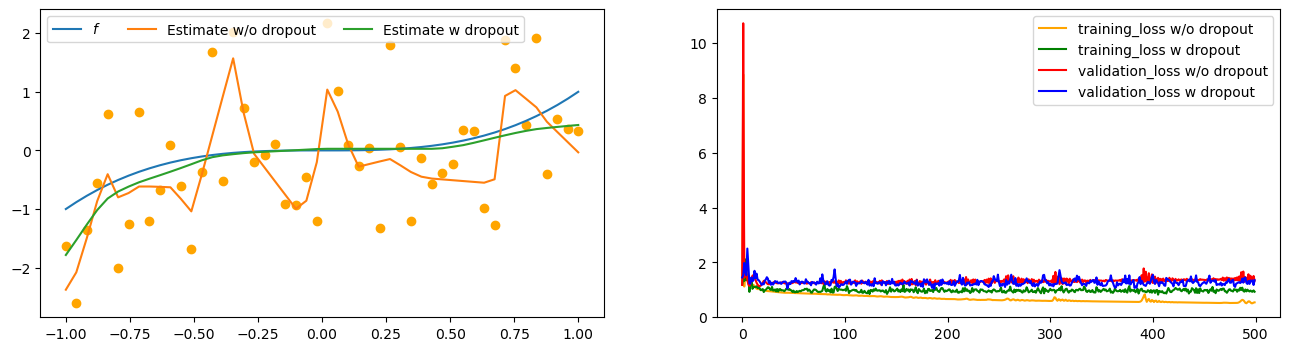

In [12]:
fig, axs = plt.subplots(1,2,figsize = (16,4))
axs[0].plot(data_train.x,data_train.f, label = "$f$")
axs[0].scatter(data_train.x,data_train.y, color = 'orange')
axs[0].plot(data.x,model(data.x).detach(),label = "Estimate w/o dropout")
axs[0].plot(data.x,model_do(data.x).detach(), label = "Estimate w dropout")
axs[0].legend(loc='upper left',ncol = 3)
axs[1].plot(train_loss, color = 'orange' , label = "training_loss w/o dropout")
axs[1].plot(training_loss_do, color = 'green' , label = "training_loss w dropout")
axs[1].plot(val_loss, color = 'red' , label = "validation_loss w/o dropout")
axs[1].plot(val_loss_do, color = 'blue' , label = "validation_loss w dropout")
axs[1].legend()
#plt.plot(data_train.x,model(data_test.x).detach(),label = "Estimate")

